In [1]:
import os
import tensorflow as tf

# Set CUDA device order and visible devices
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7,8,9"

# Set the device
device = '/cpu:0'
if tf.config.experimental.list_physical_devices('GPU'):
    try:
        # Restrict TensorFlow to only use the second GPU
        gpus = tf.config.experimental.list_physical_devices('GPU')
        if gpus:
            tf.config.experimental.set_visible_devices(gpus[8], 'GPU')
            device = '/gpu:8'
    except RuntimeError as e:
        print(e)

print("device", device)

2024-07-17 18:39:18.772784: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-17 18:39:18.794494: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-17 18:39:18.808855: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-17 18:39:18.818576: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-17 18:39:18.837896: I tensorflow/core/platform/cpu_feature_guar

device /gpu:8


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import h5py

In [3]:



        
import h5py
import numpy as np

def load_data(file_path, num_images):
    images = []
    bounding_boxes = []
    centers = []

    with h5py.File(file_path, 'r') as h5file:
        for i in range(num_images):
            # Load image data
            image_dataset = f'image_{i}_image'
            image_data = np.array(h5file[image_dataset])
            images.append(image_data)

            # Load bounding boxes
            bbox_dataset = f'image_{i}_bounding_boxes_training'
            bbox_data = np.array(h5file[bbox_dataset])
            bounding_boxes.append(bbox_data)

            # Load center positions
            center_dataset = f'image_{i}_center_positions_training'
            center_data = np.array(h5file[center_dataset])
            centers.append(center_data)

    # Convert lists to NumPy arrays for easier handling in deep learning pipelines
    images = np.array(images)
    bounding_boxes = np.array(bounding_boxes)
    centers = np.array(centers)

    return images, bounding_boxes, centers

# Example usage
file_path = '/home/da886/ElectronCountingProject/90KImages_64x64Training.h5'
num_images = 90000

images, bounding_boxes, centers = load_data(file_path, num_images)

# Verify shapes
print(f'Images shape: {images.shape}')
print(f'Bounding boxes shape: {bounding_boxes.shape}')
print(f'Centers shape: {centers.shape}')


Images shape: (90000, 64, 64)
Bounding boxes shape: (90000, 280, 5)
Centers shape: (90000, 280, 3)


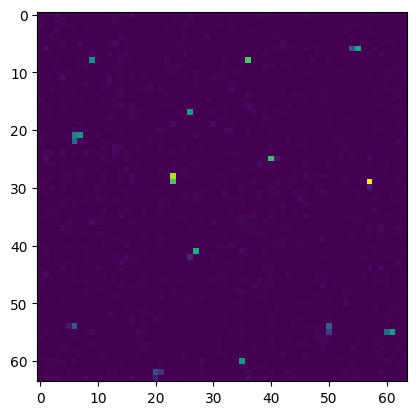

In [4]:
plt.imshow(images[4])

In [4]:
centers[2]

array([[ 1. , 41.5, 34.5],
       [ 1. ,  7.5, 51.5],
       [ 1. ,  9.5, 47.5],
       [ 1. , 49.5, 41.5],
       [ 1. ,  6.5, 49.5],
       [ 1. , 59.5, 11.5],
       [ 1. ,  3.5, 60.5],
       [ 1. , 47.5, 60.5],
       [ 1. , 59.5, 26.5],
       [ 1. , 32.5, 61.5],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
 

In [5]:
# Assuming images and centers are already defined
image_normalized = (images + 1e-9) / 64
center_coordinates = centers / [1, 64, 64]  # Normalizing the center coordinates
images_np = image_normalized
probabilities = np.array(center_coordinates[:, :, :-2])
probabilities =  tf.expand_dims(probabilities, axis=1)
center_coordinates_np = np.array(center_coordinates[:, :, 1:])
center_coordinates_np = tf.expand_dims(center_coordinates_np, axis=1)
batch_size = 128
dataset = tf.data.Dataset.from_tensor_slices((images_np, {'x_prob_reshape': probabilities, 'x_midpoints_reshape': center_coordinates_np}))
dataset = dataset.shuffle(buffer_size=10000,reshuffle_each_iteration= True).batch(batch_size)




2024-07-17 18:41:08.805403: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79078 MB memory:  -> device: 8, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ce:00.0, compute capability: 8.0


In [35]:
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64), dtype=tf.float64, name=None), {'x_prob_reshape': TensorSpec(shape=(None, 1, 280, 1), dtype=tf.float64, name=None), 'x_midpoints_reshape': TensorSpec(shape=(None, 1, 280, 2), dtype=tf.float64, name=None)})>

In [14]:
images_np[4]

array([[1.5625e-11, 1.5625e-11, 1.5625e-11, ..., 1.5625e-11, 1.5625e-11,
        3.1250e-02],
       [6.2500e-02, 1.5625e-11, 1.5625e-11, ..., 1.5625e-11, 1.5625e-02,
        1.5625e-11],
       [6.2500e-02, 1.5625e-11, 1.5625e-11, ..., 1.5625e-11, 1.5625e-11,
        1.5625e-11],
       ...,
       [1.5625e-11, 1.5625e-02, 3.1250e-02, ..., 1.5625e-11, 3.1250e-02,
        1.5625e-02],
       [1.5625e-11, 1.5625e-02, 1.5625e-11, ..., 3.1250e-02, 1.5625e-11,
        1.5625e-11],
       [1.5625e-11, 4.6875e-02, 4.6875e-02, ..., 1.5625e-11, 3.1250e-02,
        1.5625e-02]])

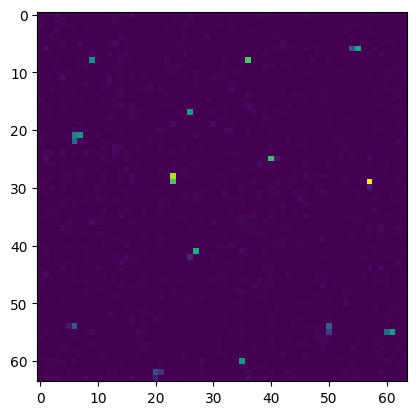

In [13]:
plt.imshow(images_np[4])

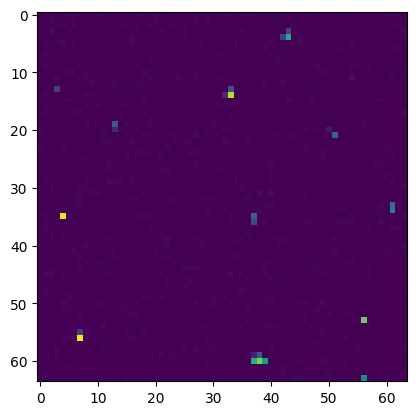

In [7]:
plt.imshow(images[0])

In [7]:
center_coordinates_np[2]

<tf.Tensor: shape=(1, 280, 2), dtype=float64, numpy=
array([[[0.6484375, 0.5390625],
        [0.1171875, 0.8046875],
        [0.1484375, 0.7421875],
        [0.7734375, 0.6484375],
        [0.1015625, 0.7734375],
        [0.9296875, 0.1796875],
        [0.0546875, 0.9453125],
        [0.7421875, 0.9453125],
        [0.9296875, 0.4140625],
        [0.5078125, 0.9609375],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       ,

In [6]:
input_shape = (64, 64, 1)
num_classes = 280
num_coordinates = 2


x_input = layers.Input(shape=input_shape)
#Layer 1
x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x_input)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) 
x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)

#Layer 2
x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)

#Layer 3
x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)

#Layer 4
x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

#Layer 5
x = layers.Conv2D(128, kernel_size=5, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) 


x = layers.Flatten()(x)
# Probability output
x_prob = layers.Dense(num_classes, activation='sigmoid', name='x_prob')(x)
x_prob_reshape = layers.Reshape((-1,num_classes,1), name='x_prob_reshape')(x_prob)

# Bounding box output
x_midpoints = layers.Dense(num_classes * num_coordinates, activation='sigmoid', name='x_midpoints')(x)
x_midpoints_reshape = layers.Reshape((-1, num_classes, num_coordinates), name='x_midpoints_reshape')(x_midpoints)




model = tf.keras.models.Model(x_input, [x_prob_reshape,x_midpoints_reshape])
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5) 


In [7]:
@tf.keras.utils.register_keras_serializable()
class MaskedMeanSquaredError(tf.keras.losses.Loss):
    def __init__(self, name="masked_mse_loss", **kwargs):
        super().__init__(name=name, **kwargs)

    def call(self, y_true, y_pred):
        # Create mask
        mask = tf.reduce_sum(y_true, axis=-1) > 0
        mask = tf.cast(mask, tf.float32)
        mask = tf.expand_dims(mask, axis=-1)

        # Apply mask to the true and predicted values
        y_true_masked = y_true * mask
        y_pred_masked = y_pred * mask

        # Calculate mean squared error
        mse = tf.reduce_mean(tf.square(y_true_masked - y_pred_masked), axis=-1)

        # Normalize the loss by the number of non-zero elements in the mask
        mask_sum = tf.reduce_sum(mask)
        masked_loss = tf.reduce_sum(mse) / mask_sum
        return masked_loss


@tf.keras.utils.register_keras_serializable()
class MaskedBinaryCrossentropy(tf.keras.losses.Loss):
    def __init__(self, name="masked_binary_crossentropy", **kwargs):
        super().__init__(name=name, **kwargs)

    def call(self, y_true, y_pred):
        # Create mask
        mask = tf.reduce_sum(y_true, axis=-1) > 0
        mask = tf.cast(mask, tf.float32)
        mask = tf.expand_dims(mask, axis=-1)

        # Apply mask to the true and predicted values
        y_true_masked = y_true * mask
        y_pred_masked = y_pred * mask

        # Calculate binary cross-entropy
        bce = tf.keras.losses.binary_crossentropy(y_true_masked, y_pred_masked)

        # Normalize the loss by the number of non-zero elements in the mask
        mask_sum = tf.reduce_sum(mask)
        masked_loss = tf.reduce_sum(bce) / mask_sum
        return masked_loss


In [8]:
model.compile(optimizer= optimizer, loss= {'x_prob_reshape': MaskedBinaryCrossentropy(), 'x_midpoints_reshape':MaskedMeanSquaredError()})   
num_epochs = 1500

In [9]:
from tensorflow.keras import layers, callbacks
# Custom callback to save the model every 10 epochs
class CustomModelCheckpoint(callbacks.Callback):
    def __init__(self, save_freq, save_path):
        super(CustomModelCheckpoint, self).__init__()
        self.save_freq = save_freq
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            self.model.save(self.save_path.format(epoch=epoch + 1))
            print(f"Model saved at epoch {epoch + 1}")

save_freq = 5  # Save every 10 epochs
save_path = "/home/da886/ElectronCountingProject/Weights from my data/weights for checkpoints 272 electrons/wtn_model_epoch_{epoch:02d}.h5"
checkpoint_callback = CustomModelCheckpoint(save_freq=save_freq, save_path=save_path)


In [8]:
# model = tf.keras.models.load_model("/home/da886/ElectronCountingProject/90000Images64x64maskedlossv1.keras")

In [10]:
model.fit(dataset,epochs=100,callbacks=[checkpoint_callback])

Epoch 1/100


I0000 00:00:1721241763.586902 2991966 service.cc:146] XLA service 0x7f7114003e50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721241763.587269 2991966 service.cc:154]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-07-17 18:42:43.689388: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-17 18:42:44.124078: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-07-17 18:42:52.592581: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[128,512,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,512,32,32]{3,2,1,0}, f32[512,512,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_qu

  3/704 ━━━━━━━━━━━━━━━━━━━━ 40s 58ms/step - loss: 0.7895  

I0000 00:00:1721241784.164061 2991966 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


704/704 ━━━━━━━━━━━━━━━━━━━━ 75s 70ms/step - loss: 0.3879
Epoch 2/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 45s 64ms/step - loss: 0.1094
Epoch 3/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 43s 61ms/step - loss: 0.0905
Epoch 4/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 43s 61ms/step - loss: 0.0854
Epoch 5/100
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0834

Model saved at epoch 5
704/704 ━━━━━━━━━━━━━━━━━━━━ 40s 57ms/step - loss: 0.0834
Epoch 6/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 42s 59ms/step - loss: 0.0824
Epoch 7/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - loss: 0.0818
Epoch 8/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/step - loss: 0.0814
Epoch 9/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - loss: 0.0812
Epoch 10/100
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0811

Model saved at epoch 10
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - loss: 0.0811
Epoch 11/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - loss: 0.0810
Epoch 12/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - loss: 0.0809
Epoch 13/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - loss: 0.0809
Epoch 14/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - loss: 0.0809
Epoch 15/100
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0809

Model saved at epoch 15
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 56ms/step - loss: 0.0809
Epoch 16/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 44s 63ms/step - loss: 0.0808
Epoch 17/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - loss: 0.0808
Epoch 18/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - loss: 0.0808
Epoch 19/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/step - loss: 0.0808
Epoch 20/100
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0808

Model saved at epoch 20
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - loss: 0.0808
Epoch 21/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - loss: 0.0808
Epoch 22/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - loss: 0.0808
Epoch 23/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - loss: 0.0808
Epoch 24/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/step - loss: 0.0808
Epoch 25/100
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0808

Model saved at epoch 25
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - loss: 0.0808
Epoch 26/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - loss: 0.0808
Epoch 27/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - loss: 0.0808
Epoch 28/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - loss: 0.0808
Epoch 29/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - loss: 0.0808
Epoch 30/100
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0808

Model saved at epoch 30
704/704 ━━━━━━━━━━━━━━━━━━━━ 40s 57ms/step - loss: 0.0808
Epoch 31/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 40s 57ms/step - loss: 0.0807
Epoch 32/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - loss: 0.0807
Epoch 33/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - loss: 0.0807
Epoch 34/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - loss: 0.0807
Epoch 35/100
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0807

Model saved at epoch 35
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - loss: 0.0807
Epoch 36/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - loss: 0.0807
Epoch 37/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - loss: 0.0806
Epoch 38/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - loss: 0.0806
Epoch 39/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - loss: 0.0806
Epoch 40/100
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0806

Model saved at epoch 40
704/704 ━━━━━━━━━━━━━━━━━━━━ 40s 57ms/step - loss: 0.0806
Epoch 41/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - loss: 0.0806
Epoch 42/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - loss: 0.0805
Epoch 43/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - loss: 0.0805
Epoch 44/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 80s 55ms/step - loss: 0.0805
Epoch 45/100
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0804

Model saved at epoch 45
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - loss: 0.0804
Epoch 46/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/step - loss: 0.0804
Epoch 47/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - loss: 0.0804
Epoch 48/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - loss: 0.0804
Epoch 49/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 56ms/step - loss: 0.0803
Epoch 50/100
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0803

Model saved at epoch 50
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - loss: 0.0803
Epoch 51/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - loss: 0.0802
Epoch 52/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - loss: 0.0802
Epoch 53/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 40s 57ms/step - loss: 0.0802
Epoch 54/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 42s 59ms/step - loss: 0.0801
Epoch 55/100
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0801

Model saved at epoch 55
704/704 ━━━━━━━━━━━━━━━━━━━━ 80s 56ms/step - loss: 0.0801
Epoch 56/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - loss: 0.0800
Epoch 57/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - loss: 0.0800
Epoch 58/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/step - loss: 0.0799
Epoch 59/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - loss: 0.0799
Epoch 60/100
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0799

Model saved at epoch 60
704/704 ━━━━━━━━━━━━━━━━━━━━ 42s 60ms/step - loss: 0.0799
Epoch 61/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - loss: 0.0798
Epoch 62/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - loss: 0.0798
Epoch 63/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 42s 59ms/step - loss: 0.0797
Epoch 64/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 42s 60ms/step - loss: 0.0797
Epoch 65/100
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0796

Model saved at epoch 65
704/704 ━━━━━━━━━━━━━━━━━━━━ 44s 62ms/step - loss: 0.0796
Epoch 66/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 43s 60ms/step - loss: 0.0796
Epoch 67/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 43s 61ms/step - loss: 0.0795
Epoch 68/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 42s 60ms/step - loss: 0.0795
Epoch 69/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 42s 59ms/step - loss: 0.0794
Epoch 70/100
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0794

Model saved at epoch 70
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - loss: 0.0794
Epoch 71/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 82s 59ms/step - loss: 0.0793
Epoch 72/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - loss: 0.0793
Epoch 73/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 81s 57ms/step - loss: 0.0792
Epoch 74/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 42s 59ms/step - loss: 0.0792
Epoch 75/100
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0791

Model saved at epoch 75
704/704 ━━━━━━━━━━━━━━━━━━━━ 40s 57ms/step - loss: 0.0791
Epoch 76/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 40s 57ms/step - loss: 0.0790
Epoch 77/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 42s 60ms/step - loss: 0.0790
Epoch 78/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - loss: 0.0789
Epoch 79/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - loss: 0.0789
Epoch 80/100
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0788

Model saved at epoch 80
704/704 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - loss: 0.0788
Epoch 81/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - loss: 0.0787
Epoch 82/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - loss: 0.0787
Epoch 83/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/step - loss: 0.0786
Epoch 84/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - loss: 0.0786
Epoch 85/100
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0785

Model saved at epoch 85
704/704 ━━━━━━━━━━━━━━━━━━━━ 40s 57ms/step - loss: 0.0785
Epoch 86/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - loss: 0.0785
Epoch 87/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - loss: 0.0784
Epoch 88/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - loss: 0.0783
Epoch 89/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - loss: 0.0783
Epoch 90/100
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0782

Model saved at epoch 90
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - loss: 0.0782
Epoch 91/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 40s 57ms/step - loss: 0.0782
Epoch 92/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/step - loss: 0.0781
Epoch 93/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - loss: 0.0780
Epoch 94/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 43s 59ms/step - loss: 0.0780
Epoch 95/100
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0779

Model saved at epoch 95
704/704 ━━━━━━━━━━━━━━━━━━━━ 40s 57ms/step - loss: 0.0779
Epoch 96/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/step - loss: 0.0779
Epoch 97/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - loss: 0.0778
Epoch 98/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - loss: 0.0777
Epoch 99/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 56ms/step - loss: 0.0777
Epoch 100/100
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0776

Model saved at epoch 100
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - loss: 0.0776


In [11]:
model.save("/home/da886/ElectronCountingProject/Weights from my data/weights for checkpoints 272 electrons/90000Images64x64maskedlosswtnv1.keras") 

In [12]:
dataset = tf.data.Dataset.from_tensor_slices((images_np, {'x_prob_reshape': probabilities, 'x_midpoints_reshape': center_coordinates_np}))
dataset = dataset.batch(100)
inputs,targets = next(iter(dataset))
# inputs,targets = next(iter(test_dataset))
output =model.predict(inputs)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step


In [13]:
import tensorflow as tf

# r = np.random.randint(0,100)
tensor1 = tf.constant(targets['x_midpoints_reshape'], dtype=tf.float64)

tensor2 = tf.constant(output[1], dtype=tf.float32)


tensor2 = tf.cast(tensor2, tf.float64)


mse_loss_fn = tf.keras.losses.MeanSquaredError()
mse_loss = mse_loss_fn(tensor1, tensor2)

print("MSE Loss:", mse_loss.numpy())

MSE Loss: 0.1846053


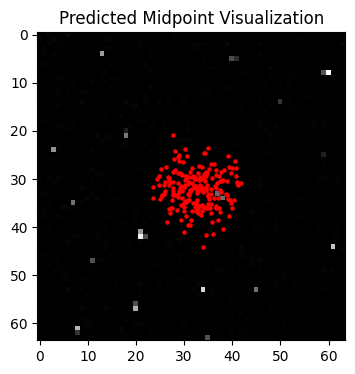

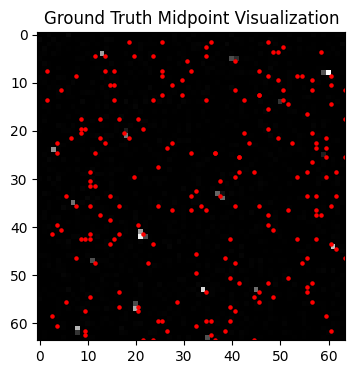

: 

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_midpoints(image, probability_vector, midpoints, threshold=0.8):
    """
    Visualizes midpoints on an image based on a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - probability_vector: A 1D tensor representing the probabilities associated with midpoints.
    - midpoints: A 2D tensor representing the midpoint coordinates (x, y).
    - threshold: Probability threshold for visualization.

    Returns:
    None (displays the image with midpoints).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    prob_vector_np = probability_vector
    midpoints_np = midpoints#.numpy() if hasattr(midpoints, 'numpy') else midpoints

    # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title("Predicted Midpoint Visualization")

    # Plot midpoints based on probability threshold
    for i, (y,x) in enumerate(midpoints_np):
        prob = prob_vector_np[i]
        if prob > threshold:
            plt.scatter(y, x, color='red', s=5)
            # if i == 0:  # Add label only once to avoid repetition in the legend
            #     plt.legend()

    plt.show()
    
    

t = np.random.randint(0,100)
# t=1
visualize_midpoints(tf.convert_to_tensor(inputs[t]), probabilities[t].numpy().squeeze(), tf.convert_to_tensor(output[1][t,0,:,:])*[64,64]) ##myprediction   

def visualize_midpoints2(image, probability_vector, midpoints, threshold=0.8):
    """
    Visualizes midpoints on an image based on a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - probability_vector: A 1D tensor representing the probabilities associated with midpoints.
    - midpoints: A 2D tensor representing the midpoint coordinates (x, y).
    - threshold: Probability threshold for visualization.

    Returns:
    None (displays the image with midpoints).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    prob_vector_np = probability_vector
    midpoints_np = midpoints#.numpy() if hasattr(midpoints, 'numpy') else midpoints

    # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title("Ground Truth Midpoint Visualization")

    # Plot midpoints based on probability threshold
    for i, (y,x) in enumerate(midpoints_np):
        prob = prob_vector_np[i]
        if prob > threshold:
            plt.scatter(y, x, color='red', s=5)
            # if i == 0:  # Add label only once to avoid repetition in the legend
            #     plt.legend()

    plt.show()     
visualize_midpoints2(tf.convert_to_tensor(inputs[t]), probabilities[t].numpy().squeeze(), tf.convert_to_tensor(center_coordinates_np[t,0,:,:])*[64,64]) ##ground truth          




In [29]:
import numpy as np

def evaluate_model(predictions, ground_truths, probability_threshold=0.9, midpoint_diff_threshold=0.05):
    pred_probabilities = predictions[0]
    pred_midpoints = predictions[1]
    gt_probabilities = ground_truths[0]
    gt_midpoints = ground_truths[1]
    
    # Valid predictions are those above the probability threshold
    valid_predictions = pred_probabilities > probability_threshold
    no_predictions = pred_probabilities <= probability_threshold

    # Calculate differences for midpoint evaluations
    midpoint_diff = np.abs(pred_midpoints - gt_midpoints)
    is_accurate_prediction = np.all(midpoint_diff <= midpoint_diff_threshold, axis=1)
    
    # True Positives: Valid predictions close enough to the ground truth
    TP = np.sum(np.logical_and(valid_predictions, is_accurate_prediction))
    
    # False Positives: Valid predictions not close enough to the ground truth
    FP = np.sum(np.logical_and(valid_predictions, ~is_accurate_prediction))
    
    # True Negatives: No predictions where no objects are actually present
    TN = np.sum(np.logical_and(no_predictions, gt_probabilities <= probability_threshold))
    
    # False Negatives: No predictions where objects are actually present
    FN = np.sum(np.logical_and(no_predictions, gt_probabilities > probability_threshold))
    
    # Metrics calculation
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    F1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    MAE = np.mean(midpoint_diff)
    MSE = np.mean(np.square(midpoint_diff))
    
    return precision, recall, F1_score, MAE, MSE

# Usage 
predictions = [output[0][0:800], output[1][0:800]]
ground_truths = [targets['x_prob_reshape'][0:800], targets['x_midpoints_reshape'][0:800]]
precision, recall, F1_score, MAE, MSE = evaluate_model(predictions, ground_truths)

print(f"Precision: {precision}, Recall: {recall}, F1 Score: {F1_score}, MAE: {MAE}, MSE: {MSE}")


Precision: 0.14074019525332435, Recall: 0.9999790708660475, F1 Score: 0.24675177120782982, MAE: 0.3580253046628268, MSE: 0.2096388443383539
